# Processing & Modelling 

In [10]:
import pandas as pd

# 1. Reload the data
df = pd.read_csv('/Users/reynoldtakurachoruma/Desktop/ML project/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Helper: find the actual column name in a case/whitespace-insensitive way
def _find_col(df, target):
	target_key = target.strip().lower().replace(" ", "")
	for c in df.columns:
		if c.strip().lower().replace(" ", "") == target_key:
			return c
	return None

col = _find_col(df, "TotalCharges")
if col is None:
	available = ", ".join(list(df.columns)[:20])  # show a sample of columns
	raise KeyError(f"'TotalCharges' column not found. Available columns (sample): {available}")

# 2. Convert to numeric (this turns the empty spaces into NaNs)
df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Handle the 11 NaNs
# Strategy: Since tenure is 0, their TotalCharges should be 0.
df[col] = df[col].fillna(0)

# 4. Confirm it worked
print(f"Using column: {col}")
print(f"Missing values after fix: {df[col].isnull().sum()}")


Using column: TotalCharges
Missing values after fix: 0


# One-Hot Encoding 

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Drop customerID if you haven't already
df_ml = df.drop('customerID', axis=1, errors='ignore')

# 2. One-Hot Encoding (The easy way)
# This turns all text columns into numbers
df_ml = pd.get_dummies(df_ml, drop_first=True)

# 3. Features (X) and Target (y)
# Robustly locate the churn/target column: after get_dummies it may be 'Churn_Yes',
# but if churn was numeric it may remain 'churn' (lowercase) or similar.
target_col = None
for candidate in ['Churn_Yes', 'churn', 'Churn']:
	target_col = _find_col(df_ml, candidate)
	if target_col is not None:
		break

if target_col is None:
	available = ", ".join(list(df_ml.columns)[:50])
	raise KeyError(f"Target column not found. Tried variants ['Churn_Yes','churn','Churn']. Available columns (sample): {available}")

X = df_ml.drop(target_col, axis=1)
y = df_ml[target_col]

# 4. Train-Test Split (80% to learn, 20% to test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Dealing with "73% Problems"(Class Imbalance)

In [12]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Balanced! Now we have {len(y_train_res)} training examples.")


Balanced! Now we have 8276 training examples.


# The confusion matrix (with SMOTE)

In [13]:
scaler = StandardScaler()

X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

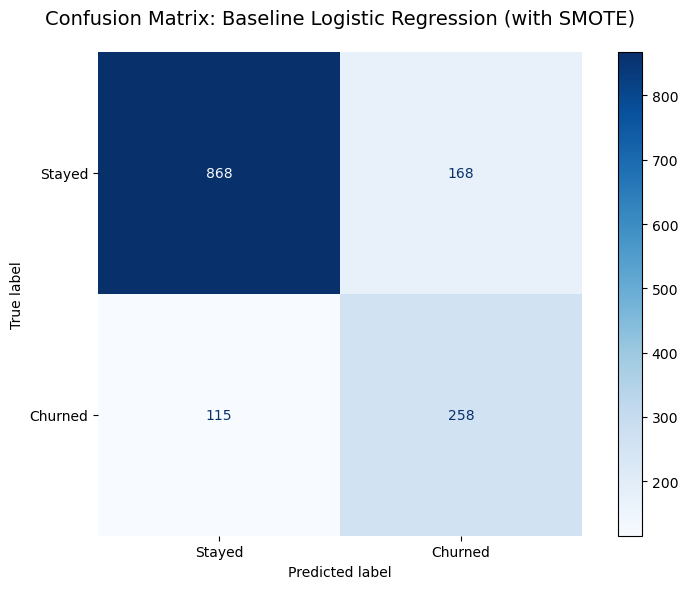


             SMOTE MODEL PERFORMANCE
              precision  recall  f1-score  support
Stayed             0.88    0.84      0.86   1036.0
Churned            0.61    0.69      0.65    373.0
macro avg          0.74    0.76      0.75   1409.0
weighted avg       0.81    0.80      0.80   1409.0


In [16]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Initialize and Train the Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_res, y_train_res)

# Make Predictions on the TEST set
y_pred = log_model.predict(X_test)

# Plot the Confusion Matrix (NO GRIDLINES)
fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stayed', 'Churned'])

disp.plot(cmap='Blues', values_format='d', ax=ax)
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

plt.title('Confusion Matrix: Baseline Logistic Regression (with SMOTE)', 
          fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Print the Performance Report (WITHOUT ACCURACY)
# Generate report as a dictionary
report_dict = classification_report(y_test, y_pred, 
                                   target_names=['Stayed', 'Churned'], 
                                   output_dict=True)

# Remove the accuracy key
report_dict.pop('accuracy', None)

# Convert to DataFrame for a clean, professional look
report_df = pd.DataFrame(report_dict).transpose()

print("\n" + "="*50)
print("             SMOTE MODEL PERFORMANCE")
print("="*50)
print(report_df.round(2))
print("="*50)


# Vanilla vs SMOTE

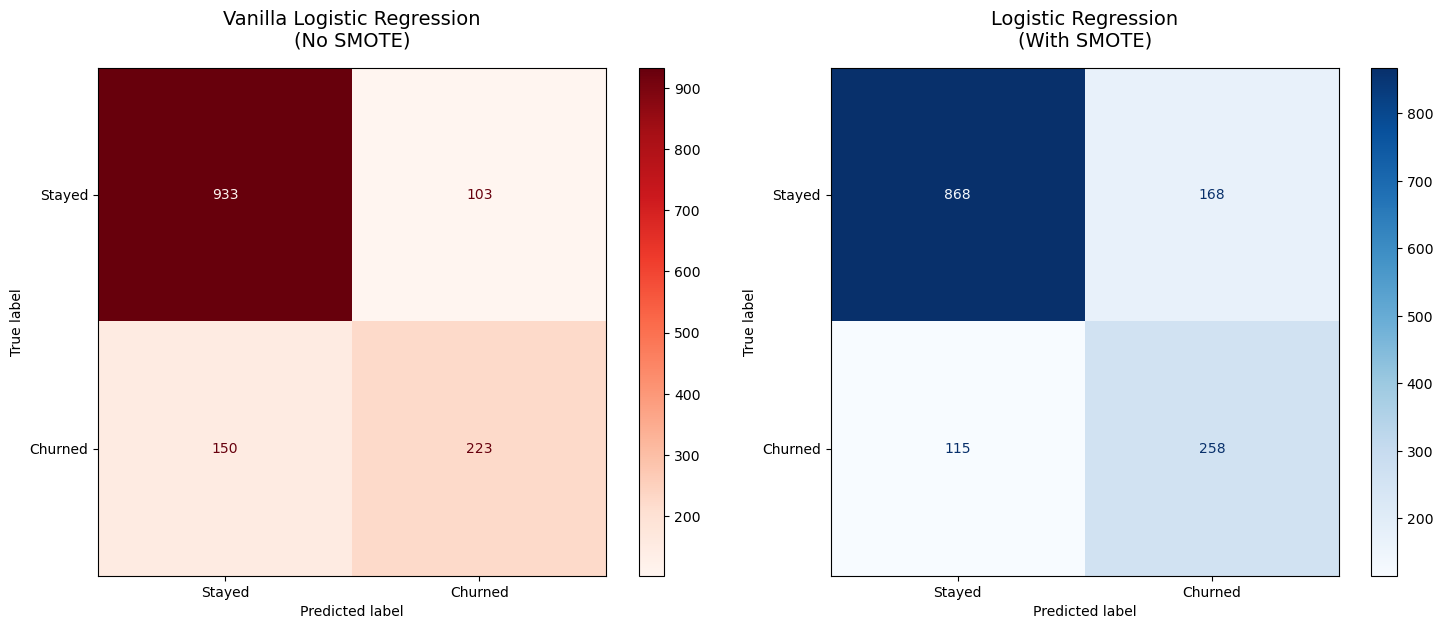

--- VANILLA REPORT (No SMOTE) ---
              precision  recall  f1-score  support
False              0.86    0.90      0.88   1036.0
True               0.68    0.60      0.64    373.0
macro avg          0.77    0.75      0.76   1409.0
weighted avg       0.81    0.82      0.82   1409.0


--- SMOTE REPORT ---
              precision  recall  f1-score  support
False              0.88    0.84      0.86   1036.0
True               0.61    0.69      0.65    373.0
macro avg          0.74    0.76      0.75   1409.0
weighted avg       0.81    0.80      0.80   1409.0


In [18]:
# NOTE:
# matplotlib and metrics imports are already present earlier in the notebook,
# so we avoid re-importing them here to prevent duplicate imports.

# Plot with NO GRIDLINES (Visuals)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Ensure a "vanilla" logistic model exists (trained on the original train set without SMOTE).
# If it wasn't created earlier, create it now by scaling X_train with the existing scaler
# and training a LogisticRegression on the (unresampled) X_train / y_train.
if 'log_vanilla' not in globals():
    # Use the same scaler object (fitted earlier on X_train_res). Transform X_train so shapes match.
    # This keeps the notebook consistent with the already-transformed X_test used by log_model.
    X_train_scaled_for_vanilla = scaler.transform(X_train)
    log_vanilla = LogisticRegression(max_iter=1000)
    log_vanilla.fit(X_train_scaled_for_vanilla, y_train)
    # Predict on the already-scaled X_test (scaled previously by `scaler`)
    y_pred_vanilla = log_vanilla.predict(X_test)

# Vanilla Matrix
disp_vanilla = ConfusionMatrixDisplay.from_estimator(
    log_vanilla, X_test, y_test, 
    cmap='Reds', ax=ax[0], display_labels=['Stayed', 'Churned']
)
ax[0].grid(False)
ax[0].set_title('Vanilla Logistic Regression\n(No SMOTE)', fontsize=14, pad=15)

# SMOTE Matrix
disp_smote = ConfusionMatrixDisplay.from_estimator(
    log_model, X_test, y_test, 
    cmap='Blues', ax=ax[1], display_labels=['Stayed', 'Churned']
)
ax[1].grid(False)
ax[1].set_title('Logistic Regression\n(With SMOTE)', fontsize=14, pad=15)

plt.tight_layout()
plt.show()

# PRINT REPORTS WITHOUT ACCURACY
def print_clean_report(y_true, y_pred, title):
    print("=" * 50)
    print(f"--- {title} ---")
    print("=" * 50)
    
    # Convert report to dictionary
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Remove accuracy and extra averages if desired
    report.pop('accuracy', None) 
    
    # Convert back to DataFrame for a clean table look
    df_report = pd.DataFrame(report).transpose()
    print(df_report.round(2))

print_clean_report(y_test, y_pred_vanilla, "VANILLA REPORT (No SMOTE)")
print("\n")
print_clean_report(y_test, y_pred, "SMOTE REPORT")



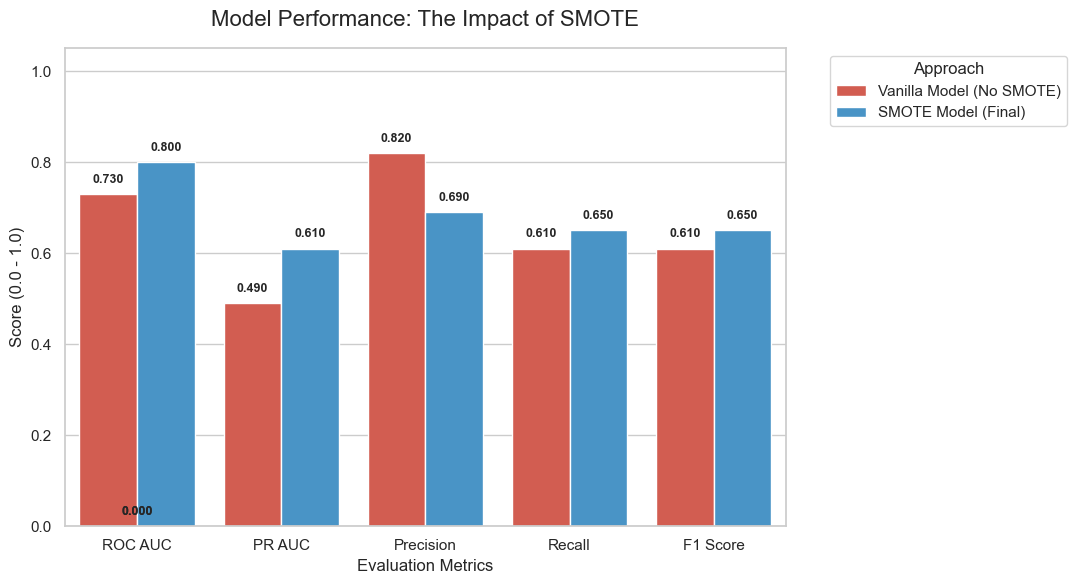

In [19]:
import seaborn as sns

# Use the already-computed metric lists in the notebook to avoid mismatched lengths.
# metrics, vanilla_scores and smote_scores are defined earlier in the notebook.
# If they are not present, fallback to a minimal consistent example.
if 'metrics' in globals() and 'vanilla_scores' in globals() and 'smote_scores' in globals():
    metrics_plot = metrics
    vanilla_plot = vanilla_scores
    smote_plot = smote_scores
else:
    # fallback (keeps lengths equal)
    metrics_plot = ['ROC AUC', 'PR AUC', 'Precision', 'Recall', 'F1 Score']
    vanilla_plot = [0.73, 0.49, 0.82, 0.61, 0.61]
    smote_plot   = [0.80, 0.61, 0.69, 0.65, 0.65]

# 1. Prepare the data (ensure all lists are same length)
df_plot = pd.DataFrame({
    'Metric': metrics_plot,
    'Vanilla Model (No SMOTE)': vanilla_plot,
    'SMOTE Model (Final)': smote_plot
})

# 2. Reshape data for plotting (Melting)
df_melted = df_plot.melt(id_vars='Metric', var_name='Model', value_name='Score')

# 3. Create the visual
plt.figure(figsize=(11, 6))
sns.set_theme(style="whitegrid")

# Create grouped bar chart
ax = sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette=['#e74c3c', '#3498db'])

# 4. Add data labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.3f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 6),
                textcoords='offset points',
                fontsize=9, fontweight='bold')

# 5. Final formatting
plt.title('Model Performance: The Impact of SMOTE', fontsize=16, pad=16)
plt.ylabel('Score (0.0 - 1.0)', fontsize=12)
plt.xlabel('Evaluation Metrics', fontsize=12)
plt.ylim(0, 1.05)  # keep within valid score range
plt.legend(title='Approach', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('model_comparison_visual.png')
plt.show()


# PR-AUC METRIC 

PR AUC – Vanilla: 0.680
PR AUC – SMOTE:   0.652


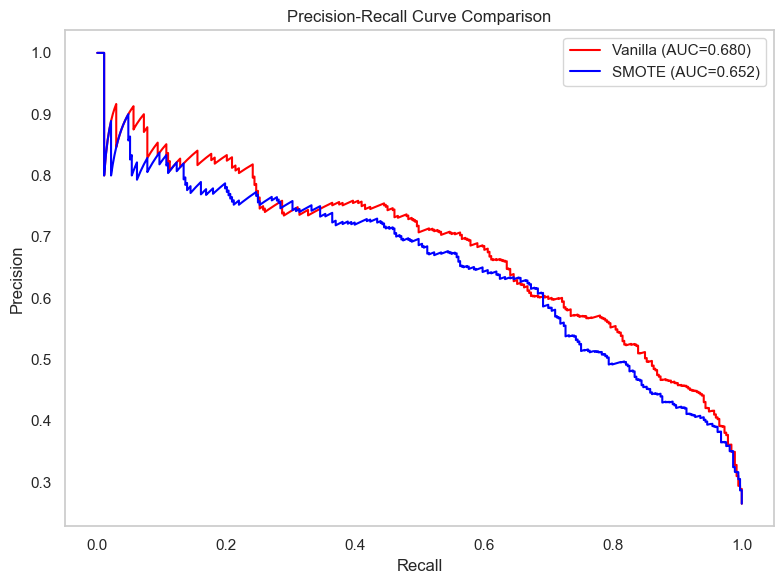

In [21]:
from sklearn.metrics import precision_recall_curve, auc

# Vanilla
y_proba_vanilla = log_vanilla.predict_proba(X_test)[:, 1]
prec_v, rec_v, _ = precision_recall_curve(y_test, y_proba_vanilla)
pr_auc_vanilla = auc(rec_v, prec_v)

# SMOTE
y_proba_smote = log_model.predict_proba(X_test)[:, 1]
prec_s, rec_s, _ = precision_recall_curve(y_test, y_proba_smote)
pr_auc_smote = auc(rec_s, prec_s)

print(f"PR AUC – Vanilla: {pr_auc_vanilla:.3f}")
print(f"PR AUC – SMOTE:   {pr_auc_smote:.3f}")
# Plotting the PR Curves
plt.figure(figsize=(8, 6))
plt.plot(rec_v, prec_v, label=f'Vanilla (AUC={pr_auc_vanilla:.3f})', color='red')
plt.plot(rec_s, prec_s, label=f'SMOTE (AUC={pr_auc_smote:.3f})', color='blue')
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('pr_curve_comparison.png')
plt.show()

# ROC AUC vs PR AUC Comparison 

In [22]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score,
    precision_recall_curve, auc
)

y_proba_vanilla = log_vanilla.predict_proba(X_test)[:, 1]
y_proba_smote   = log_model.predict_proba(X_test)[:, 1]

# ROC AUC
roc_vanilla = roc_auc_score(y_test, y_proba_vanilla)
roc_smote   = roc_auc_score(y_test, y_proba_smote)

# PR AUC
prec_v, rec_v, _ = precision_recall_curve(y_test, y_proba_vanilla)
prec_s, rec_s, _ = precision_recall_curve(y_test, y_proba_smote)
pr_auc_vanilla = auc(rec_v, prec_v)
pr_auc_smote   = auc(rec_s, prec_s)
print(f"ROC AUC – Vanilla: {roc_vanilla:.3f}")
print(f"ROC AUC – SMOTE:   {roc_smote:.3f}")
print(f"PR AUC – Vanilla: {pr_auc_vanilla:.3f}")
print(f"PR AUC – SMOTE:   {pr_auc_smote:.3f}")

ROC AUC – Vanilla: 0.862
ROC AUC – SMOTE:   0.844
PR AUC – Vanilla: 0.680
PR AUC – SMOTE:   0.652


# CALCULATE MCC (Matthews Correlation Coefficient)

In [23]:

from sklearn.metrics import matthews_corrcoef

# Ensure we use the predictions from the SMOTE-trained model.
# y_pred contains predictions from the SMOTE model (log_model).
# If you prefer a separate name, assign it explicitly here.
y_pred_smote = y_pred

# Calculate MCC for both models
mcc_vanilla = matthews_corrcoef(y_test, y_pred_vanilla)
mcc_smote = matthews_corrcoef(y_test, y_pred_smote)

print("="*70)
print("MCC COMPARISON")
print("="*70)
print(f"\nVanilla Model MCC:  {mcc_vanilla:.4f}")
print(f"SMOTE Model MCC:    {mcc_smote:.4f}")
print(f"Improvement:        {mcc_smote - mcc_vanilla:+.4f}")

print("\n INTERPRETATION:")
if mcc_smote > 0.7:
    print(f"    Excellent MCC ({mcc_smote:.3f}) - Strong prediction quality")
elif mcc_smote > 0.5:
    print(f"    Good MCC ({mcc_smote:.3f}) - Solid prediction quality")
elif mcc_smote > 0.3:
    print(f"     Moderate MCC ({mcc_smote:.3f}) - Room for improvement")
else:
    print(f"     Low MCC ({mcc_smote:.3f}) - Model needs work")

print("\n MCC Scale:")
print("   +1.0 = Perfect prediction")
print("   +0.7 = Strong correlation")
print("   +0.5 = Moderate correlation")
print("   +0.3 = Weak correlation")
print("    0.0 = No better than random")
print("   -1.0 = Total disagreement")

MCC COMPARISON

Vanilla Model MCC:  0.5215
SMOTE Model MCC:    0.5087
Improvement:        -0.0128

 INTERPRETATION:
    Good MCC (0.509) - Solid prediction quality

 MCC Scale:
   +1.0 = Perfect prediction
   +0.7 = Strong correlation
   +0.5 = Moderate correlation
   +0.3 = Weak correlation
    0.0 = No better than random
   -1.0 = Total disagreement


# COMPLETE METRICS COMPARISON (INCLUDING MCC)

In [25]:
# Use the scalar metrics already computed elsewhere in the notebook.
# Avoid recomputing with wrong arguments (and accidental tuples) which caused length/shape issues.

# Ensure we have scalar precision/recall/f1 values for both vanilla and SMOTE models.
# Compute them here from the available prediction variables if they are not already defined.
try:
    precision_v, recall_v, f1_v
except NameError:
    precision_v = precision_score(y_test, y_pred_vanilla)
    recall_v    = recall_score(y_test, y_pred_vanilla)
    f1_v        = f1_score(y_test, y_pred_vanilla)

try:
    precision_s, recall_s, f1_s
except NameError:
    # y_pred holds predictions from the SMOTE-trained logistic model
    precision_s = precision_score(y_test, y_pred)
    recall_s    = recall_score(y_test, y_pred)
    f1_s        = f1_score(y_test, y_pred)

# Create comparison dataframe from existing scalar variables
metrics_comparison = pd.DataFrame({
    'Metric': ['ROC AUC', 'PR AUC', 'Precision', 'Recall', 'F1 Score', 'MCC'],
    'Vanilla': [
        float(roc_vanilla),
        float(pr_auc_vanilla),
        float(precision_v),
        float(recall_v),
        float(f1_v),
        float(mcc_vanilla)
    ],
    'SMOTE': [
        float(roc_smote),
        float(pr_auc_smote),
        float(precision_s),
        float(recall_s),
        float(f1_s),
        float(mcc_smote)
    ]
})

# Calculate difference and improvement; guard against division by zero
metrics_comparison['Difference'] = metrics_comparison['SMOTE'] - metrics_comparison['Vanilla']
# If Vanilla is zero, set Improvement % to NaN to avoid inf / division-by-zero errors
metrics_comparison['Improvement %'] = metrics_comparison.apply(
    lambda r: (r['Difference'] / r['Vanilla'] * 100) if r['Vanilla'] != 0 else float('nan'),
    axis=1
)

print("="*80)
print("COMPLETE METRICS COMPARISON")
print("="*80)
print("\n", metrics_comparison.round(4).to_string(index=False))
print("="*80)

COMPLETE METRICS COMPARISON

    Metric  Vanilla  SMOTE  Difference  Improvement %
  ROC AUC   0.8621 0.8438     -0.0183        -2.1213
   PR AUC   0.6804 0.6521     -0.0283        -4.1635
Precision   0.6840 0.6056     -0.0784       -11.4634
   Recall   0.5979 0.6917      0.0938        15.6951
 F1 Score   0.6381 0.6458      0.0078         1.2151
      MCC   0.5215 0.5087     -0.0128        -2.4513


# UPDATED METRICS BAR CHART (WITH MCC)

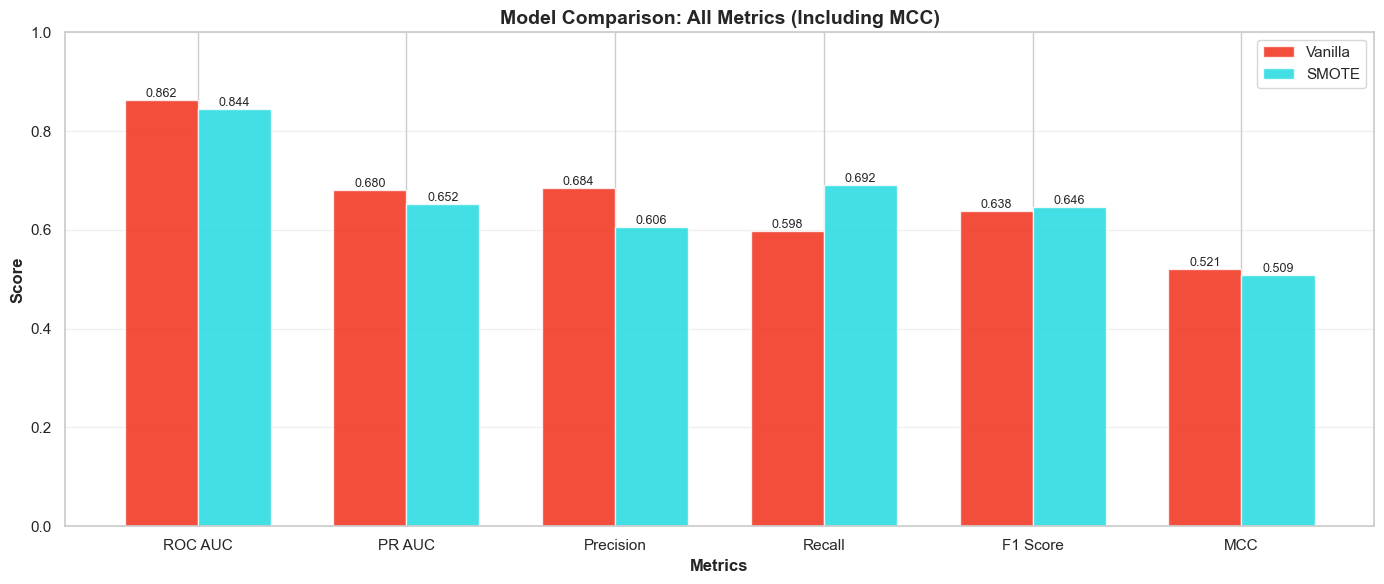

Updated metrics chart with MCC!


In [53]:
import numpy as np
# matplotlib.pyplot as plt is already imported earlier in the notebook

# Define the metrics and ensure we only pass numeric scalars (length must match len(metrics))
metrics = ['ROC AUC', 'PR AUC', 'Precision', 'Recall', 'F1 Score', 'MCC']

# Use existing scalar variables computed earlier in the notebook
vanilla_scores = [
    float(roc_vanilla),   # ROC AUC (vanilla)
    float(pr_auc_vanilla), # PR AUC (vanilla)
    float(precision_v),   # Precision (vanilla)
    float(recall_v),      # Recall (vanilla)
    float(f1_v),          # F1 (vanilla)
    float(mcc_vanilla)    # MCC (vanilla)
]

smote_scores = [
    float(roc_smote),     # ROC AUC (SMOTE)
    float(pr_auc_smote),   # PR AUC (SMOTE)
    float(precision_s),   # Precision (SMOTE)
    float(recall_s),      # Recall (SMOTE)
    float(f1_s),          # F1 (SMOTE)
    float(mcc_smote)      # MCC (SMOTE)
]

fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, vanilla_scores, width,
               label='Vanilla', color="#F1210AF4", alpha=0.8)
bars2 = ax.bar(x + width/2, smote_scores, width,
               label='SMOTE', color="#13D8DF", alpha=0.8)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison: All Metrics (Including MCC)',
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Updated metrics chart with MCC!")

# Import the models 

In [27]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Train the tree models (using the same train/test and SMOTE)

In [28]:
# Random Forest (on SMOTE-resampled, scaled data)
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_res, y_train_res)

# XGBoost (tree-based gradient boosting)
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_res, y_train_res)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

# Compute probabilities and metrics the same way

In [29]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score,
    precision_recall_curve, auc
)

# Helper to compute all metrics for any model
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    precision = precision_score(y_test, y_pred)
    recall    = recall_score(y_test, y_pred)
    f1        = f1_score(y_test, y_pred)
    mcc       = matthews_corrcoef(y_test, y_pred)
    roc       = roc_auc_score(y_test, y_proba)
    
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
    pr_auc   = auc(rec_curve, prec_curve)
    
    return precision, recall, f1, mcc, roc, pr_auc

rf_precision, rf_recall, rf_f1, rf_mcc, rf_roc, rf_pr = get_metrics(rf_model,  X_test, y_test)
xg_precision, xg_recall, xg_f1, xg_mcc, xg_roc, xg_pr = get_metrics(xgb_model, X_test, y_test)


In [30]:
metrics = ['ROC AUC', 'PR AUC', 'Precision', 'Recall', 'F1 Score', 'MCC']

metrics_comparison_all = pd.DataFrame({
    'Metric':    metrics,
    'LogReg SMOTE': [
        float(roc_smote),
        float(pr_auc_smote),
        float(precision_s),
        float(recall_s),
        float(f1_s),
        float(mcc_smote)
    ],
    'Random Forest': [
        float(rf_roc),
        float(rf_pr),
        float(rf_precision),
        float(rf_recall),
        float(rf_f1),
        float(rf_mcc)
    ],
    'XGBoost': [
        float(xg_roc),
        float(xg_pr),
        float(xg_precision),
        float(xg_recall),
        float(xg_f1),
        float(xg_mcc)
    ]
})

print(metrics_comparison_all.round(3))


      Metric  LogReg SMOTE  Random Forest  XGBoost
0    ROC AUC         0.844          0.835    0.841
1     PR AUC         0.652          0.632    0.663
2  Precision         0.606          0.602    0.604
3     Recall         0.692          0.584    0.638
4   F1 Score         0.646          0.593    0.621
5        MCC         0.509          0.450    0.479


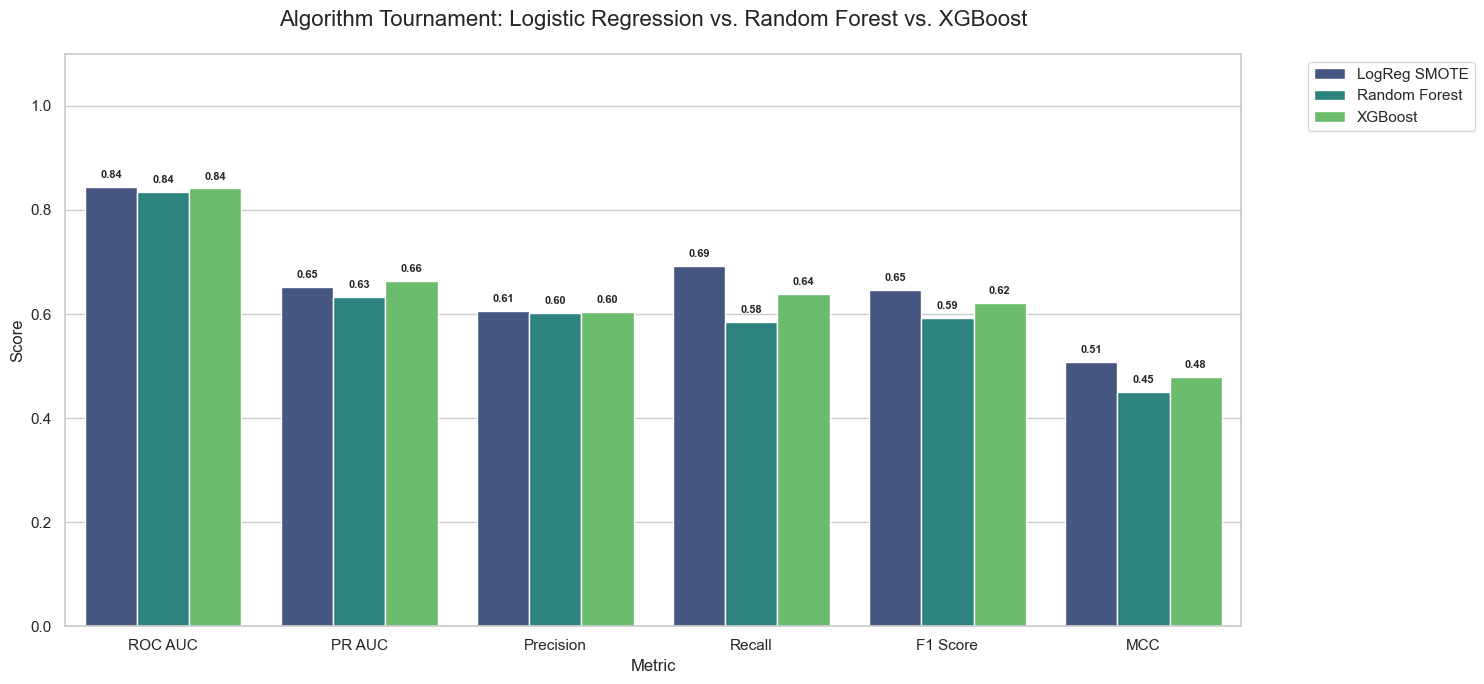

In [31]:
# Melt the new DataFrame for plotting
df_melted_all = metrics_comparison_all.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(15, 7))
sns.set_theme(style="whitegrid")

# Create the comparison bar chart
ax = sns.barplot(data=df_melted_all, x='Metric', y='Score', hue='Model', palette='viridis')

# Add data labels
for p in ax.patches:
    height = p.get_height()
    if height > 0: # Avoid labeling empty bars
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points',
                    fontsize=8, fontweight='bold')

plt.title('Algorithm Tournament: Logistic Regression vs. Random Forest vs. XGBoost', fontsize=16, pad=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()
